In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')


In [12]:
data = data[data['total sulfur dioxide']<200] # dropping some outliers

### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

In [60]:
def getData(threshold):

    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>threshold] = 1

    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()

    labels = labels[:,None]

    train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, train_size=0.9)

    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)
    # test_data.tensors[0].shape[0]
    
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.__len__())
    return train_loader, test_loader

In [5]:
class modelClass(nn.Module):
    def __init__(self, actFun):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.bNorm1 = nn.BatchNorm1d(16) # number of units in the layer
        self.hidden1 = nn.Linear(16, 32)

        self.bNorm2 = nn.BatchNorm1d(32) # number of units in the layer
        self.hidden2 = nn.Linear(32, 20)

        self.output = nn.Linear(20, 1)

        self.actFun = actFun

    def forward(self, data, doBN):

        actFun = getattr(torch.nn, self.actFun)

        x = actFun()(self.input(data))

        if(doBN):
            x = self.bNorm1(x)
            x = actFun()(self.hidden1(x))

            x = self.bNorm2(x)
            x = actFun()(self.hidden2(x))
        else:
            x = actFun()(self.hidden1(x))
            x = actFun()(self.hidden2(x))
        
        x = self.output(x)

        return x


In [6]:
test = getattr(torch.nn, 'ReLU')
test

torch.nn.modules.activation.ReLU

In [7]:
def createModel(actfun):
    ANN = modelClass(actFun=actfun)
    
    learningRate = 0.001

    lossFunction = torch.nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(params=ANN.parameters(), lr=learningRate)

    return ANN, lossFunction, optimizer

In [57]:
epochs = 500
def trainModel(doBN, train_loader, test_loader, ANN, lossFunction, optimizer):
    
    losses = []
    trainAcc = []
    testAcc = []
    for _ in range(epochs):

        batchAcc = []
        batchLoss = []
        for trainX, trainY in train_loader:
            yHat = ANN.forward(trainX, doBN)
            # print(trainY)
            # print(yHat)
            loss = lossFunction(yHat, trainY)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append((torch.mean(((yHat > 0).float() == trainY).float()) * 100).item()) # no sigmoid
            batchLoss.append(loss.item())
        
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        testX, testY = next(iter(test_loader))
        with torch.no_grad():
            predLabels = ANN.forward(testX, doBN)
        testAcc.append((torch.mean(((predLabels > 0).float() == testY).float()) * 100).item()) # no sigmoid
    
    return trainAcc, testAcc, losses, ANN

In [115]:
thresholds = [4, 5, 6]

trainByThresh = np.zeros((epochs, len(thresholds)))
testByThresh = np.zeros((epochs, len(thresholds)))
lossesByThresh = np.zeros((epochs, len(thresholds)))
testAccPerQual = np.zeros((2, len(thresholds)))
barPlotText = np.zeros((2, len(thresholds)))

for ti, thresh in enumerate(thresholds):
    train_loader, test_loader = getData(thresh)
    ANN, lossFunction, optimizer = createModel('LeakyReLU')
    trainByThresh[:,ti], testByThresh[:,ti], lossesByThresh[:,ti], ANN = trainModel(False, train_loader, test_loader, ANN, lossFunction, optimizer)
    testX, testY = next(iter(test_loader))
    with torch.no_grad():
        predLabels = ANN.forward(testX, False)
    
    itemAccuracy = ((predLabels > 0).float() == testY).float() # contains '1' where predLabels match actual labels and '0' otherwise
    testAccPerQual[0, ti] = (torch.mean(itemAccuracy[testY==0]) * 100).item() # Bad Quality. Checking for the itemAccuracy where it is actually a Bad wine.
    testAccPerQual[1, ti] = (torch.mean(itemAccuracy[testY==1]) * 100).item() # Good Quality. Checking for the itemAccuracy where it is actually a Good wine.
    barPlotText[0, ti] = torch.sum(train_loader.dataset.tensors[1]==0).item() # Bad Quality
    barPlotText[1, ti] = torch.sum(train_loader.dataset.tensors[1]==1).item() # Good Quality


/var/folders/sb/75v06dpj77ldyknd005qr5kw0000gn/T/ipykernel_12438/1002700922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>threshold] = 1
/var/folders/sb/75v06dpj77ldyknd005qr5kw0000gn/T/ipykernel_12438/1002700922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>threshold] = 1
/var/folders/sb/75v06dpj77ldyknd005qr5kw0000gn/T/ipykernel_12438/1002700922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [116]:
testAccPerQual

array([[ 25.        ,  85.29411316,  94.9640274 ],
       [100.        ,  78.26087189,  80.95238495]])

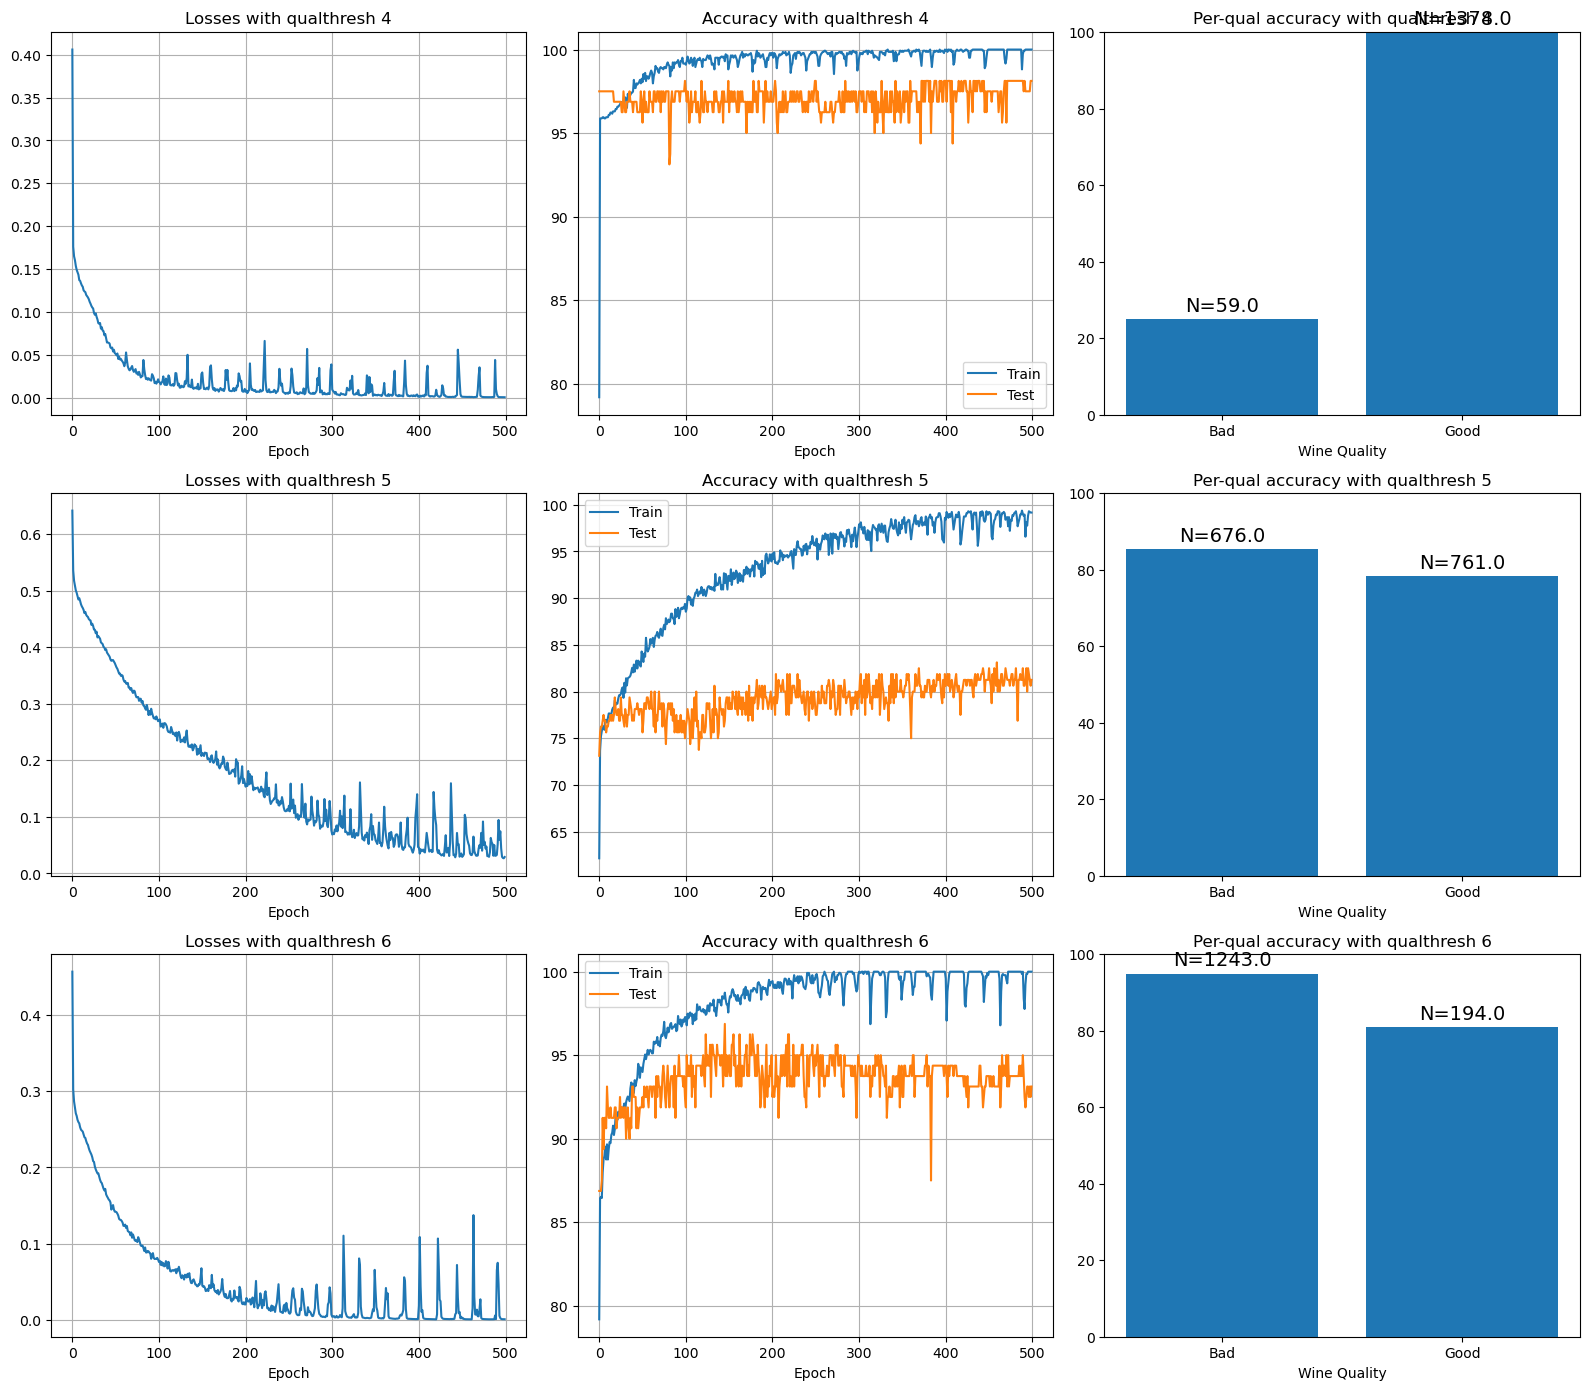

In [118]:
fig,ax = plt.subplots(3,3,figsize=(16,14))

for row, thresh in enumerate(thresholds):
    for col in range(3):
        
        if col==0:
            ax[row][0].set_title(f'Losses with qualthresh {thresh}')
            ax[row][0].set_xlabel('Epoch')
            ax[row][0].plot(lossesByThresh[:,row])
            ax[row][0].grid()
        elif col==1:
            ax[row][1].set_title(f'Accuracy with qualthresh {thresh}')
            ax[row][1].set_xlabel('Epoch')
            ax[row][1].plot(trainByThresh[:,row])
            ax[row][1].plot(testByThresh[:,row])
            ax[row][1].legend(['Train', 'Test'])
            ax[row][1].grid()

        else:
            bh = ax[row][2].bar(['Bad', 'Good'], testAccPerQual[:,row])
            ax[row][2].set_ylim([0,100])
            ax[row][2].set_title(f'Per-qual accuracy with qualthresh {thresh}')
            ax[row][2].set_xlabel('Wine Quality')
            # print the counts on top of each bar
            for i,r in enumerate(bh):
                N = barPlotText[:,row][i]
                ax[row][2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
                        'N=%s'%N, ha='center', va='bottom', fontsize=14)
plt.tight_layout()
plt.show()

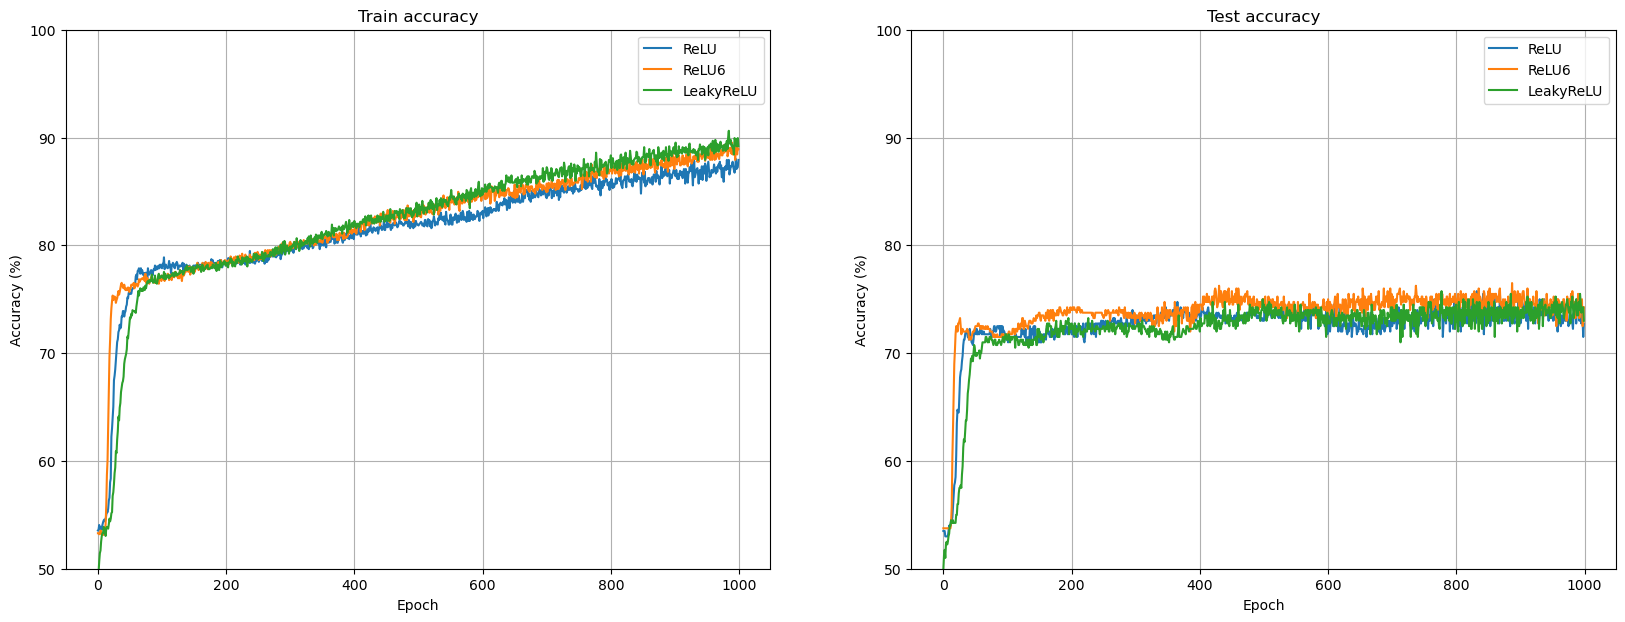

In [16]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()